## Accessing files

- Accessing files, storing data and creating necessary global variables that will be used throughout the different tasks.

In [2]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

data_path = "./data"

# Loading and concatinating the price files to a dataframe
price_files = glob(os.path.join(data_path, "DayAheadPrices_12.1.D", "*.csv"))
prices = pd.concat([pd.read_csv(file, delimiter="\t") for file in price_files], ignore_index=True)

# Filtering for relevant MapCode and hourly resolution
prices = prices[prices["MapCode"].isin(["NO2", "DE_LU"])]
prices = prices[prices["ResolutionCode"] == "PT60M"]

# Setting DateTime as index for TimeSeries Analysis
prices["DateTime"] = pd.to_datetime(prices["DateTime"])
prices.set_index("DateTime", inplace=True)

# Separating NO2 and DE_LU data
prices_no2 = prices[prices["MapCode"] == "NO2"]
prices_de = prices[prices["MapCode"] == "DE_LU"]

# Loading and concatinating the flow files to a dataframe
flow_files = glob(os.path.join(data_path, "PhysicalFlows_12.1.G", "*.csv"))
flows = pd.concat([pd.read_csv(file, delimiter="\t") for file in flow_files], ignore_index=True)

# Filtering for relevant OutMapCode/InMapCode
flows = flows[(flows["OutMapCode"].isin(["NO2", "DE_LU"])) | (flows["InMapCode"].isin(["NO2", "DE_LU"]))]

# Setting DateTime as index for TimeSeries Analysis
flows["DateTime"] = pd.to_datetime(flows["DateTime"])
flows.set_index("DateTime", inplace=True)

# Separating NO2 export and import
exp_no2 = flows[(flows["OutMapCode"] == "NO2") & (flows["InMapCode"] == "DE_LU")]
imp_no2 = flows[(flows["OutMapCode"] == "DE_LU") & (flows["InMapCode"] == "NO2")]


## Task 1

- Making a line plot that shows the development of electricity prices in NO2 and Germany through visualization of the hourly electricity prices in a time period from January 1, 2019, to December 31, 2023.

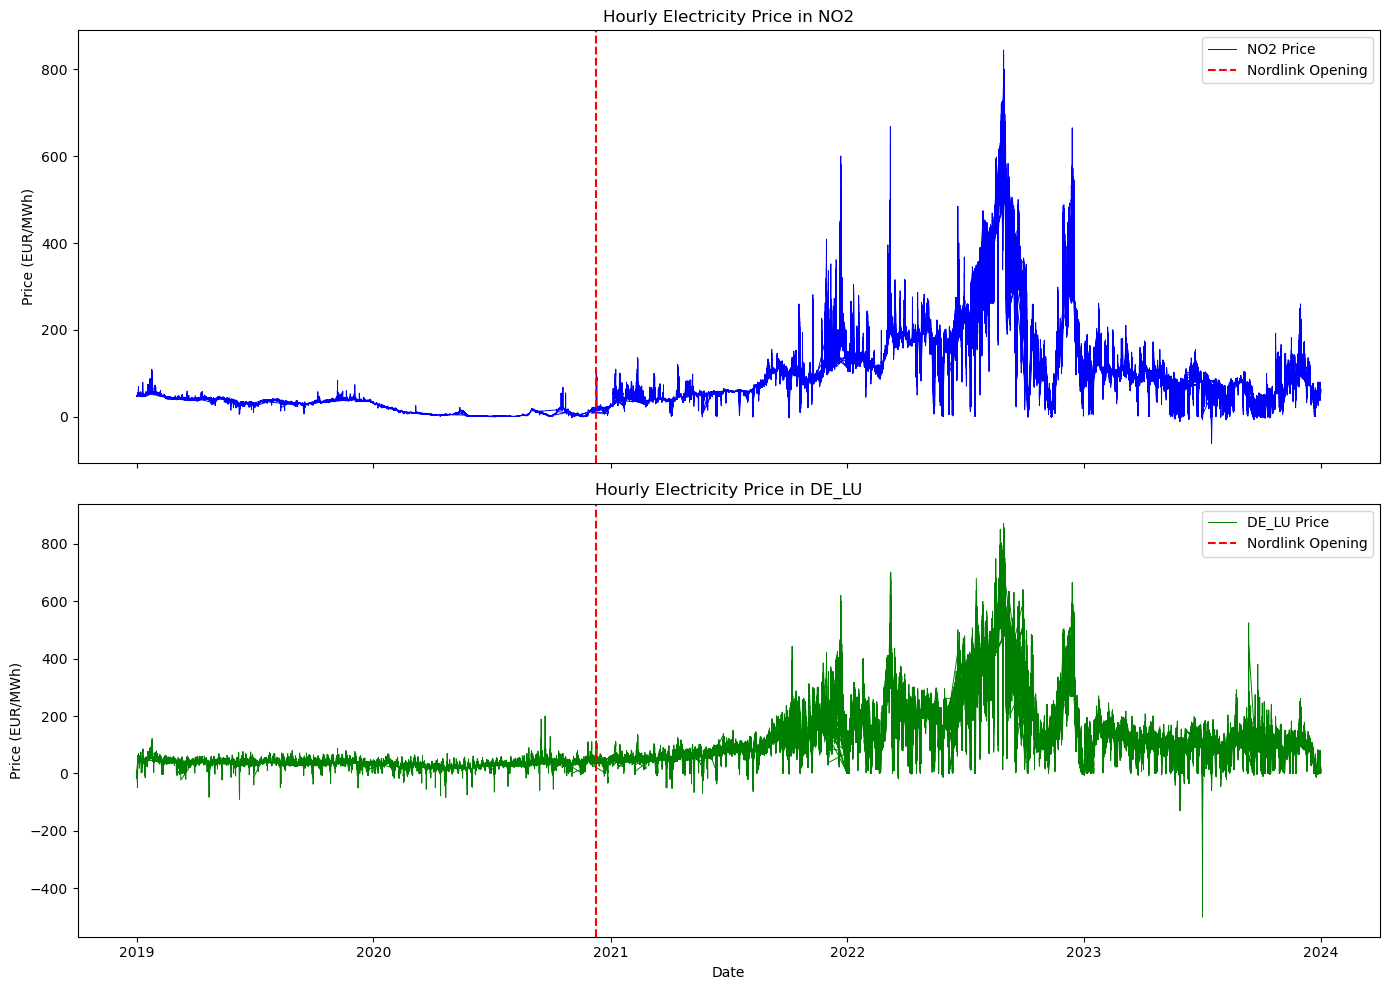

In [3]:
# Define the date of Nordlink opening for vertical line
nordlink_opening = pd.to_datetime("2020-12-09")

# Plotting Task 1: Hourly electricity prices for NO2 and DE_LU
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# First subplot for NO2
ax1.plot(prices_no2.index, prices_no2["Price"], label="NO2 Price", color="blue", linewidth=0.7)
ax1.axvline(nordlink_opening, color="red", linestyle="--", label="Nordlink Opening")
ax1.set_title("Hourly Electricity Price in NO2")
ax1.set_ylabel("Price (EUR/MWh)")
ax1.legend()

# Second subplot for DE_LU
ax2.plot(prices_de.index, prices_de["Price"], label="DE_LU Price", color="green", linewidth=0.7)
ax2.axvline(nordlink_opening, color="red", linestyle="--", label="Nordlink Opening")
ax2.set_title("Hourly Electricity Price in DE_LU")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price (EUR/MWh)")
ax2.legend()

# Saving the figure to a file
plt.tight_layout()
plt.savefig("figure_task1.png")
plt.show()


### Conclusion:

Over time, electricity prices in NO2 and Germany have become much more volatile, especially in 2022 and early 2023. After the opening of Nordlink on December 9, 2020, a trend in increasing electricity prices could be observed in both NO2 and Germany. The negative electricity prices in mid-2023 may translate to too high of a supply compared to the level of demand at the time. This can be explained by lowered seasonal demand in the summer as well as high energy production due to more sunlight, surges of wind, much rainfall and snowmelt. 

----------------

## Task 2

- Sorting and storing descriptive statistics of hourly electricity prices in NO2 and Germany (DE_LU) to determine if electricity prices have become more volatile in recent years.

In [4]:
# Calculate yearly descriptive statistics for hourly electricity prices in NO2 and DE_LU
stats_no2 = prices_no2["Price"].groupby(prices_no2.index.year).agg(["mean", "median", "std", "min", "max"]).round(2)
stats_de = prices_de["Price"].groupby(prices_de.index.year).agg(["mean", "median", "std", "min", "max"]).round(2)

# Rename columns to prepare for multi-level structure
stats_no2.columns = ["Mean", "Median", "Std", "Min", "Max"]
stats_de.columns = ["Mean", "Median", "Std", "Min", "Max"]

# Combine with multi-level columns
stats_combined = pd.concat([stats_no2, stats_de], axis=1, keys=["Norway (NO2)", "Germany (DE_LU)"])

# Save the table to an Excel file
stats_combined.to_excel("table_task2.xlsx")

# Display the combined DataFrame
stats_combined

Norway (NO2)                                Germany (DE_LU)          \
                 Mean  Median     Std    Min     Max            Mean  Median   
DateTime                                                                       
2019            39.26   38.81    8.23   5.86  109.45           37.67   38.06   
2020             9.29    6.95    8.26  -1.73   99.92           30.47   30.99   
2021            75.11   59.34   47.22  -1.97  600.16           96.85   75.48   
2022           211.28  181.13  125.85   0.04  844.00          235.44  208.34   
2023            79.44   80.46   36.28 -61.84  261.85           95.18   98.02   

                                  
             Std     Min     Max  
DateTime                          
2019       15.52  -90.01  121.46  
2020       17.50  -83.94  200.04  
2021       73.68  -69.00  620.00  
2022      142.82  -19.04  871.00  
2023       47.58 -500.00  524.27

### Conclusion:

The standard deviation from 2021-2023 shows increased price volatiliy, spiking in 2022. This tendency for more extreme prices is also seen in the large gap between the minima and maxima. Average prices have increased by more than 100% from 2019 to 2023. When looking at price development in Germany compared to Norway, it is evident that electricity prices in Germany is more expensive and more volatile. After the pening of Nordlink in late 2020, the average price surged by more than 800% in Norway the following year, compared to around 300% in Germany. 

--------------

## Task 3

- Creating a bar plot that shows annual sums of imports and exports of electricity in NO2 to determine if NO2 exports more energy than it imports from Germany, and if this has changed over time.

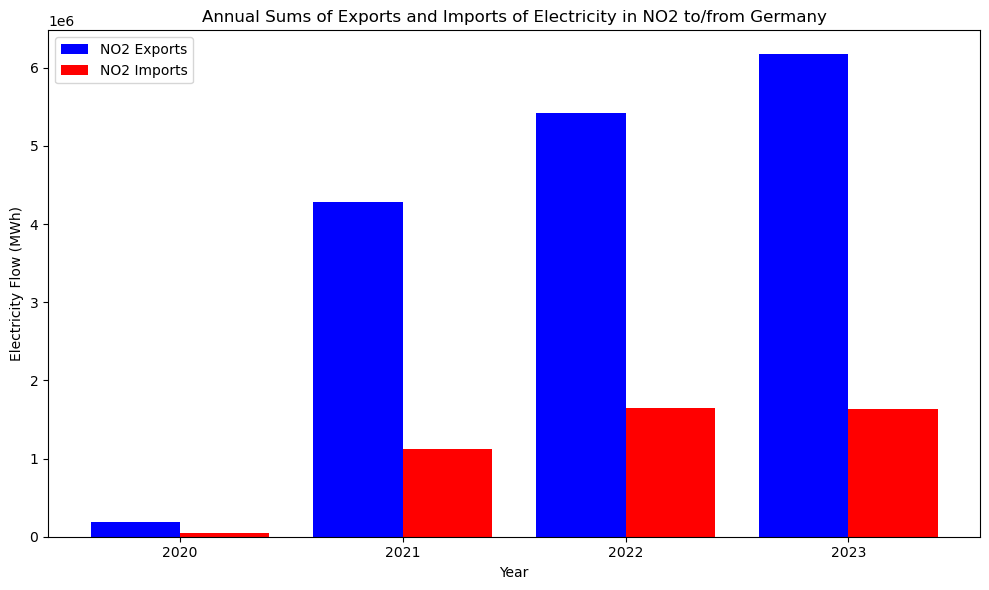

In [5]:
# Calculating annual sums of exports and imports for NO2
annual_exports_no2 = exp_no2["FlowValue"].resample("YE").sum()
annual_imports_no2 = imp_no2["FlowValue"].resample("YE").sum()

# Convert the index to year integers for direct use in plotting
years = annual_exports_no2.index.year

# Creating a bar plot for annual exports and imports
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(years - 0.2, annual_exports_no2.values, width=0.4, label="NO2 Exports", color="blue")
ax.bar(years + 0.2, annual_imports_no2.values, width=0.4, label="NO2 Imports", color="red")

# Adding labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Electricity Flow (MWh)")
ax.set_title("Annual Sums of Exports and Imports of Electricity in NO2 to/from Germany")
ax.legend()

# Set x-axis to display only integer years
ax.set_xticks(years)

# Save the plot to a file
plt.tight_layout()
plt.savefig("figure_task3.png")
plt.show()

### Conclusion:

NO2 exports more energy to Germany than it imports from Germany, and it has been like this in all the years from 2020 to 2023. Over the years, both the annual sums of exports and imports have increased. The annual sum of import increased drastically from 2020 to 2021, followed by a slower increase in 2022 and 2023. However, this change is almost nothing compared to the increase in annual sum of exports, which has exploded since 2020. All in all, NO2 exports much more energy to Germany than it imports. 

----------

## Task 4

- Creating a line plot that shows the weekly sum of net exports of electricity from NO2 to Germany to investigate whether there are times during the year in which NO2 imports more electricity from Germany than it exports (aka. if the net exports of electricity from NO2 to Germany has ever been negative)

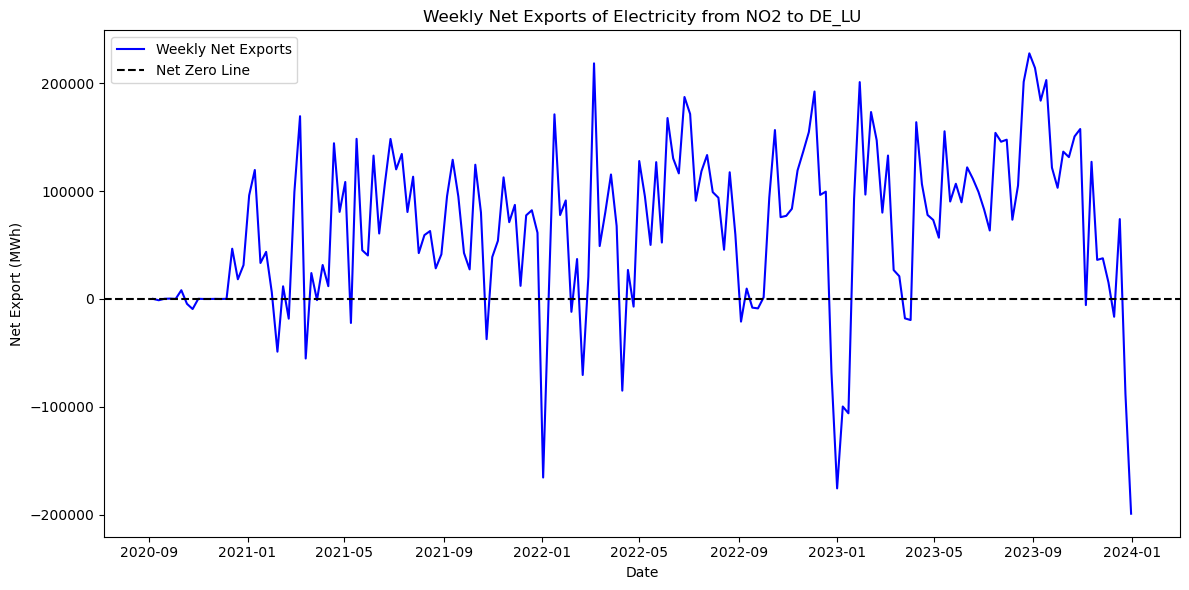

In [6]:
# Calculate weekly net exports as exports - imports
weekly_exports = exp_no2["FlowValue"].resample("W").sum()
weekly_imports = imp_no2["FlowValue"].resample("W").sum()
weekly_net_exports = weekly_exports - weekly_imports

# Plotting the weekly net exports
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_net_exports.index, weekly_net_exports, label="Weekly Net Exports", color="blue")

# Adding a horizontal line at y=0 for reference
ax.axhline(0, color="black", linestyle="--", label="Net Zero Line")

# Adding labels, title, and legend
ax.set_xlabel("Date")
ax.set_ylabel("Net Export (MWh)")
ax.set_title("Weekly Net Exports of Electricity from NO2 to DE_LU")
ax.legend()

# Save the plot to a file
plt.tight_layout()
plt.savefig("figure_task4.png")
plt.show()

### Conclusion:

The graph shows that NO2 is mainly a net exporter of electricity, but still there are times during the year where NO2 tend to import more than it has exports. Generally, January is a month where we import a lot of electricity, and in this month the line plot showed NO2 to be a repeating net importer. This is possibly due to increased demand and decreased supply.

------------

## Task 5

- Creating a scatter plot between the weekly sum of net exports in NO2 and the weekly average price difference between Germany and NO2 to investigate if NO2 tends to export more electricity to Germany whenever the electricity price in Germany is higher relative to the price in NO2.

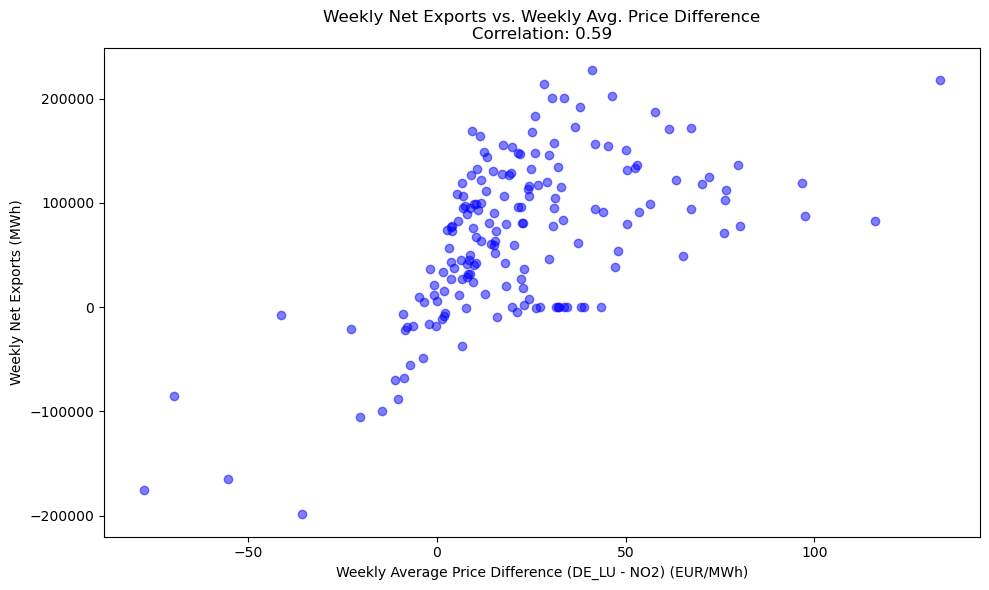

In [7]:
# Step 1: Calculate the hourly price difference (DE_LU - NO2)
hourly_price_diff = prices_de["Price"] - prices_no2["Price"]

# Step 2: Calculate the weekly average of the hourly price difference
weekly_avg_price_diff = hourly_price_diff.resample("W").mean()

# Step 3: Calculate weekly net exports (reusing the calculation from Task 4)
weekly_exports = exp_no2["FlowValue"].resample("W").sum()
weekly_imports = imp_no2["FlowValue"].resample("W").sum()
weekly_net_exports = weekly_exports - weekly_imports

# Step 4: Ensure both series align for plotting
weekly_avg_price_diff, weekly_net_exports = weekly_avg_price_diff.align(weekly_net_exports, join='inner')

# Step 5: Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(weekly_avg_price_diff, weekly_net_exports, color="blue", alpha=0.5)

# Calculate and display the correlation coefficient
correlation = weekly_avg_price_diff.corr(weekly_net_exports)
ax.set_title(f"Weekly Net Exports vs. Weekly Avg. Price Difference\nCorrelation: {correlation:.2f}")

# Add labels
ax.set_xlabel("Weekly Average Price Difference (DE_LU - NO2) (EUR/MWh)")
ax.set_ylabel("Weekly Net Exports (MWh)")

# Save the plot to a file
plt.tight_layout()
plt.savefig("figure_task5.png")
plt.show()

### Conclusion:

There seems to be a relationship between the weekly sum of net exports and the weekly average price difference. When the electricity prices in Germany are higher relative to the prices in NO2, NO2 tends to export more electricity to Germany. In fact, the higher the electricity prices, the higher net export. But this relationship goes both ways, and when prices in NO2 are higher relative to Germany, NO2 tend to import more than it exports. The correlation coefficient between the weekly sum of net exports and the weekly average price difference is 0.59, meaning that the relationship is positive.

## Task 6

gasdsvd